In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)

import extraction_squares, pre_processing_data

'''if operating_system == 'curnagl':
    name_of_variable= pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS/variable_list_80_mean.csv')
    path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS'
else:'''
name_of_variable= pd.read_csv('data/variable_list_levels.csv')
path_data = 'data'

storm_dates = pd.read_csv('pre_processing/tracks/storm_dates.csv')
path_tracks_1h = 'pre_processing/tracks/ALL_TRACKS/tracks_1h'
#path_tracks_1h_non_EU = 'pre_processing/tracks/ALL_TRACKS/tracks_1h_non_EU'
dataset = 'datasets_1h'
#dataset_non_EU = 'datasets_1h_non_EU'
levels = pd.read_csv('data/levels.csv')

In [2]:
X_train, X_test, X_validation, y_train, y_test, y_validation, X_all_3d, y_all_3d = extraction_squares.X_y_datasets_EU(name_of_variable, storm_dates, path_data, path_tracks_1h, dataset, False)

Shape of the X 3D ndarray: (96, 472, 364)
Shape of the y 3D ndarray: (96, 472, 4)
Storm Training: [ 0  2  3  4  5  6  7 11 12 13 14 16 17 18 19 20 21 22 23 24 25 27 28 29
 31 34 35 36 37 38 39 40 42 43 44 46 47 48 50 53 54 56 57 58 61 64 66 69
 70 71 73 75 76 77 78 79 81 82 83 85 86 87 88 90 92 93 94 95]
Storm Test: [ 1  9 10 15 26 33 52 59 60 62 63 68 74 84]
Storm Valid: [ 8 30 32 41 45 49 51 55 65 67 72 80 89 91]
Order of the stats : 'max', 'min', 'mean', 'std'


In [3]:
# X_train
X_train_standardized, y_train_standardized_max, y_train_standardized_mean, var_stat_all_x = pre_processing_data.data_preparation_ML(X_train, y_train, name_of_variable, levels)
# X_test 
X_test_standardized, y_test_standardized_max, y_test_standardized_mean, var_stat_all_x = pre_processing_data.data_preparation_ML(X_test, y_test, name_of_variable, levels)
# X_validation
X_validation_standardized, y_validation_standardized_max, y_validation_standardized_mean, var_stat_all_x = pre_processing_data.data_preparation_ML(X_validation, y_validation, name_of_variable, levels)

In [7]:
# reshape the X_training into a 2D array

X_all_2d = X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2])
# same for y_all_3d
y_all_2d = y_train.reshape(y_train.shape[0]*y_train.shape[1],y_train.shape[2])

# drop all the rows with nan values

X_all_2d = pd.DataFrame(X_all_2d)
X_all_2d_non_na = X_all_2d.dropna()
y_all_2d = pd.DataFrame(y_all_2d)
y_all_2d_non_na = y_all_2d.dropna()

# rename the columns by the name of the variables by adding also the stat of the variable (max, min, mean, std)

stats = ['max', 'min', 'mean', 'std']
var_stat = []
var_stat_all = []

for var in name_of_variable['variables']:
    for stat in stats:
        var_stat = f'{var}_{stat}'
        var_stat_all.append(var_stat)

# drop instantaneous variables, u and v wind components

var_stat_all_x = [var for var in var_stat_all if 'inst' not in var]
instantaneous = ['instantaneous_10m_wind_gust_max', 'instantaneous_10m_wind_gust_min', 'instantaneous_10m_wind_gust_mean', 'instantaneous_10m_wind_gust_std']

X_all_2d_non_na.columns = var_stat_all_x
y_all_2d_non_na.columns = instantaneous

y_mean = y_all_2d_non_na.drop(columns=['instantaneous_10m_wind_gust_max', 'instantaneous_10m_wind_gust_min', 'instantaneous_10m_wind_gust_std'])
y_max = y_all_2d_non_na.drop(columns=['instantaneous_10m_wind_gust_min', 'instantaneous_10m_wind_gust_mean', 'instantaneous_10m_wind_gust_std'])

# pop the level 0 in levels
if 0 in levels['levels']:
    levels['levels'].pop(0)

# Reset the index to ensure alignment
levels.reset_index(drop=True, inplace=True)
levels = levels[levels['levels'] <= 300]

# drop columns with 10m_u_component_of_wind and 10m_v_component_of_wind variables + specific_rain_water_content from level 10 to 300 (no values)

X_all_2d_non_na = X_all_2d_non_na.drop(columns=['10m_u_component_of_wind_max', 
                                                '10m_u_component_of_wind_min', 
                                                '10m_u_component_of_wind_mean', 
                                                '10m_u_component_of_wind_std', 
                                                '10m_v_component_of_wind_max', 
                                                '10m_v_component_of_wind_min', 
                                                '10m_v_component_of_wind_mean', 
                                                '10m_v_component_of_wind_std',
])
X_all_2d_non_na = X_all_2d_non_na.drop(columns=[f'specific_rain_water_content_{level}_max' for level in levels['levels']])
X_all_2d_non_na = X_all_2d_non_na.drop(columns=[f'specific_rain_water_content_{level}_mean' for level in levels['levels']])
X_all_2d_non_na = X_all_2d_non_na.drop(columns=[f'specific_rain_water_content_{level}_min' for level in levels['levels']])
X_all_2d_non_na = X_all_2d_non_na.drop(columns=[f'specific_rain_water_content_{level}_std' for level in levels['levels']])

var_stat_all_x = [
    var for var in var_stat_all_x 
    if all(
        f'specific_rain_water_content_{level}' not in var 
        for level in levels['levels']
    )
]
# using RandomForests to find the most important features

X_standardized = (X_all_2d_non_na - X_all_2d_non_na.mean()) / X_all_2d_non_na.std()
y_standardized_max = (y_max - y_max.mean()) / y_max.std()
y_standardized_mean = (y_mean - y_mean.mean()) / y_mean.std()

In [4]:
nan_x = X_train_standardized.isna().sum()

In [7]:
# Create a random forest Regressor
rf_max = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
rf_mean = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)

# Create a xgb Regressor
xgb_max = xgb.XGBRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
xgb_mean = xgb.XGBRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)

# Create a GradientBoosting Regressor
gb_max = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
gb_mean = GradientBoostingRegressor(n_estimators = 100, random_state = 42)

# Create a DecisionTree Regressor
dt_max = DecisionTreeRegressor(random_state = 42)
dt_mean = DecisionTreeRegressor(random_state = 42)

# Create a Logistic Regression
log_reg_max = LogisticRegression(random_state = 42)
log_reg_mean = LogisticRegression(random_state = 42)

# Train the model on training data
#rf_max.fit(X_all_2d_non_na, y_max)
#rf_mean.fit(X_all_2d_non_na, y_mean)
rf_max.fit(X_train_standardized, y_train_standardized_max)
rf_mean.fit(X_train_standardized, y_train_standardized_mean)

xgb_max.fit(X_train_standardized, y_train_standardized_max)
xgb_mean.fit(X_train_standardized, y_train_standardized_mean)

gb_max.fit(X_train_standardized, y_train_standardized_max)
gb_mean.fit(X_train_standardized, y_train_standardized_mean)

dt_max.fit(X_train_standardized, y_train_standardized_max)
dt_mean.fit(X_train_standardized, y_train_standardized_mean)

#log_reg_max.fit(X_train_standardized, y_train_standardized_max)
#log_reg_mean.fit(X_train_standardized, y_train_standardized_mean)

/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages

DecisionTreeRegressor(random_state=42)

In [14]:
# See the prediction of the model on the test data
#predictions_max = rf_max.predict(X_all_2d_non_na)
#predictions_mean = rf_mean.predict(X_all_2d_non_na)
rf_predictions_max = rf_max.predict(X_test_standardized)

#xgb_predictions_max = xgb_max.predict(X_all_2d_non_na)
#xgb_predictions_mean = xgb_mean.predict(X_all_2d_non_na)
xgb_predictions_max = xgb_max.predict(X_test_standardized)

#gb_predictions_max = gb_max.predict(X_all_2d_non_na)
#gb_predictions_mean = gb_mean.predict(X_all_2d_non_na)
gb_predictions_max = gb_max.predict(X_test_standardized)

#dt_predictions_max = dt_max.predict(X_all_2d_non_na)
#dt_predictions_mean = dt_mean.predict(X_all_2d_non_na)
dt_predictions_max = dt_max.predict(X_test_standardized)

#log_reg_predictions_max = log_reg_max.predict(X_all_2d_non_na)
#log_reg_predictions_mean = log_reg_mean.predict(X_all_2d_non_na)
#log_reg_predictions_max = log_reg_max.predict(X_test_standardized)

# Calculate mean squared error

mse_rf_max = np.mean((rf_predictions_max - y_test_standardized_max)**2)
mse_xgb_max = np.mean((xgb_predictions_max - y_test_standardized_max)**2)
mse_gb_max = np.mean((gb_predictions_max - y_test_standardized_max)**2)
mse_dt_max = np.mean((dt_predictions_max - y_test_standardized_max)**2)

Feature ranking for max of RF:
1. feature geopotential_1000_std (0.5665545568949217)
2. feature surface_latent_heat_flux_std (0.0857642411041476)
3. feature mean_surface_latent_heat_flux_std (0.08395569199432988)
4. feature mean_sea_level_pressure_std (0.05468128163134457)
5. feature vertical_velocity_850_std (0.034594005595774545)
6. feature surface_latent_heat_flux_min (0.018993178896022218)
7. feature mean_surface_latent_heat_flux_min (0.016351970443566125)
8. feature geopotential_1000_min (0.005788683791708096)
9. feature vertical_velocity_800_std (0.005498348254511522)
10. feature mean_sea_level_pressure_min (0.0040763994481491685)
11. feature vertical_velocity_900_std (0.003205407560253074)
12. feature mean_surface_sensible_heat_flux_std (0.002679398885988986)
13. feature geopotential_500_min (0.0022802985445834582)
14. feature vertical_velocity_800_min (0.002251486306203405)
15. feature geopotential_500_std (0.002023878446304117)
16. feature convective_precipitation_mean (0.0018

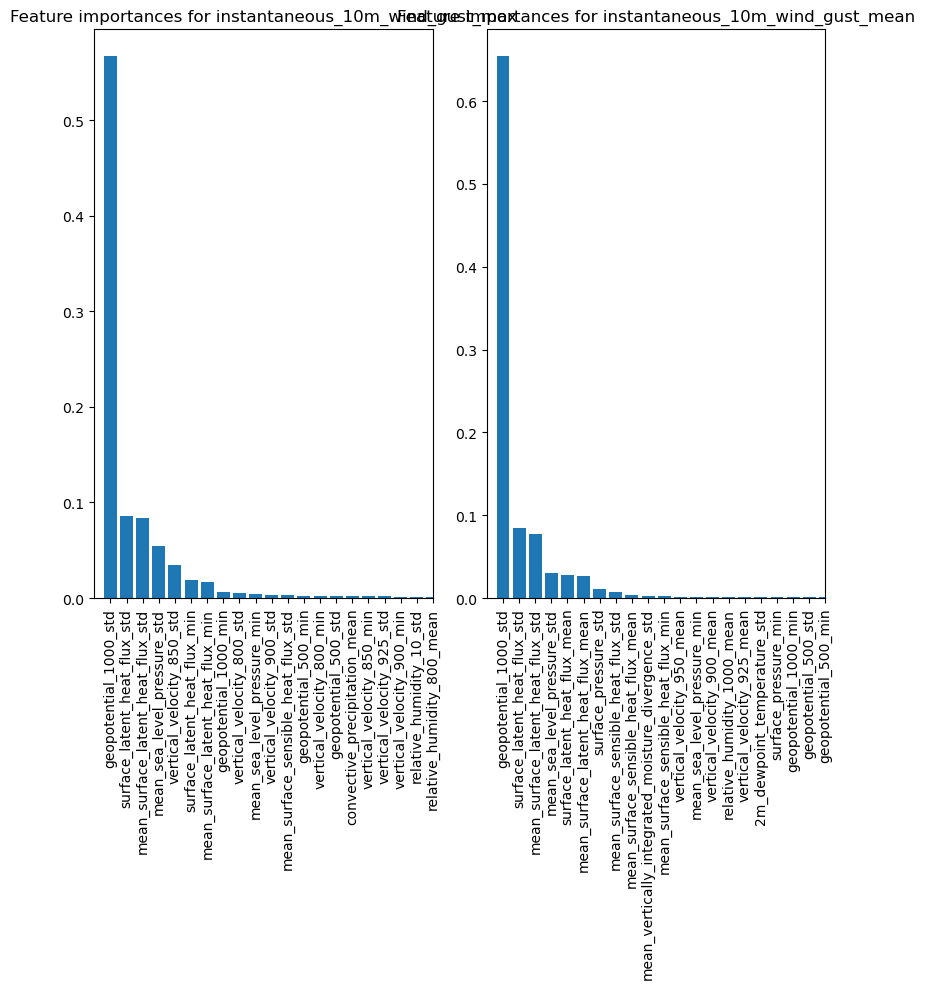

In [17]:
# Get the feature importance
importances_max = rf_max.feature_importances_
importances_mean = rf_mean.feature_importances_

# Get the feature importance for xgb
importances_max_xgb = xgb_max.feature_importances_
importances_mean_xgb = xgb_mean.feature_importances_

# Sort the features
indices_max = np.argsort(importances_max)[::-1]
indices_mean = np.argsort(importances_mean)[::-1]
var_stat_all_sorted_max = [var_stat_all_x[i] for i in indices_max]
var_stat_all_sorted_mean = [var_stat_all_x[i] for i in indices_mean]

indices_max_xgb = np.argsort(importances_max_xgb)[::-1]
indices_mean_xgb = np.argsort(importances_mean_xgb)[::-1]
var_stat_all_sorted_max_xgb = [var_stat_all_x[i] for i in indices_max_xgb]
var_stat_all_sorted_mean_xgb = [var_stat_all_x[i] for i in indices_mean_xgb]


# Print the feature ranking
print("Feature ranking for max of RF:")
for f in range(X_all_2d_non_na.shape[1]):
    print(f"{f+1}. feature {var_stat_all_sorted_max[f]} ({importances_max[indices_max[f]]})")

print("Feature ranking for max of XGB:")
for f in range(X_all_2d_non_na.shape[1]):
    print(f"{f+1}. feature {var_stat_all_sorted_max_xgb[f]} ({importances_max_xgb[indices_max_xgb[f]]})")

# Plot the feature importances of the forest
subset = 20

# with 2 plots, 1 for the max and 1 for the mean

fig, axes = plt.subplots(1, 2, figsize=(8, 10))  # 2 rows, 1 column

axes[0].set_title("Feature importances for instantaneous_10m_wind_gust_max")
axes[0].bar(range(X_all_2d_non_na.shape[1]), importances_max[indices_max], align="center")
axes[0].set_xticks(range(X_all_2d_non_na.shape[1]), var_stat_all_sorted_max, rotation=90)
axes[0].set_xlim([-1, subset])

axes[1].set_title("Feature importances for instantaneous_10m_wind_gust_mean")
axes[1].bar(range(X_all_2d_non_na.shape[1]), importances_mean[indices_mean], align="center")
axes[1].set_xticks(range(X_all_2d_non_na.shape[1]), var_stat_all_sorted_mean, rotation=90)
axes[1].set_xlim([-1, subset])

plt.tight_layout()
plt.show()

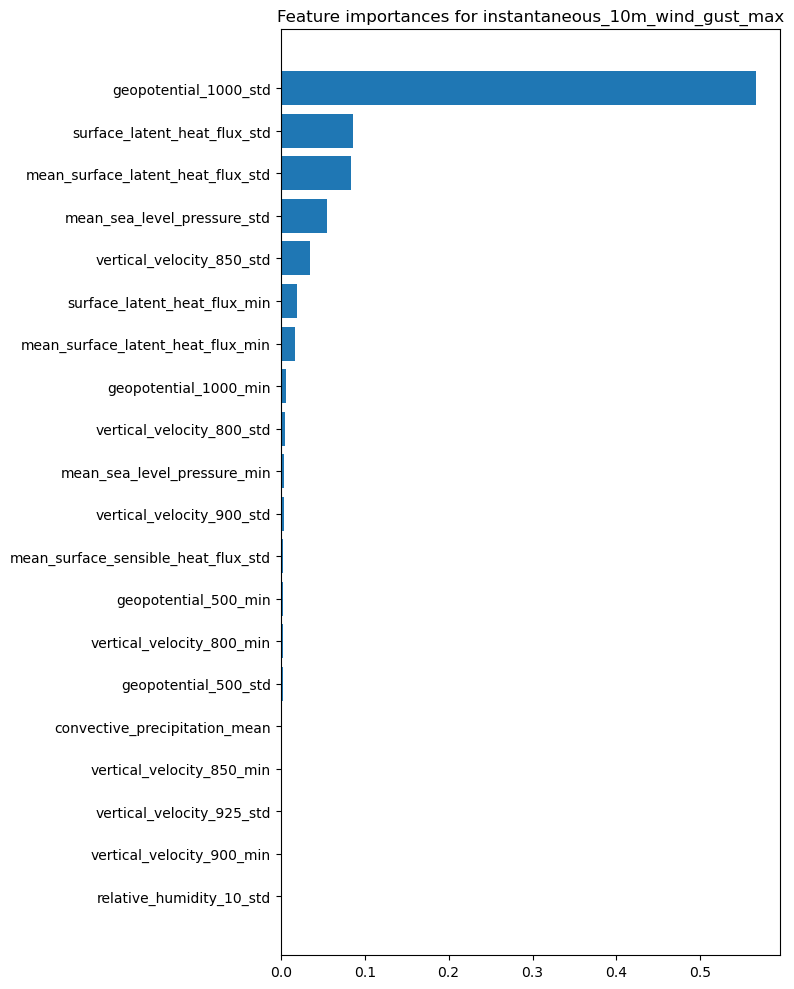

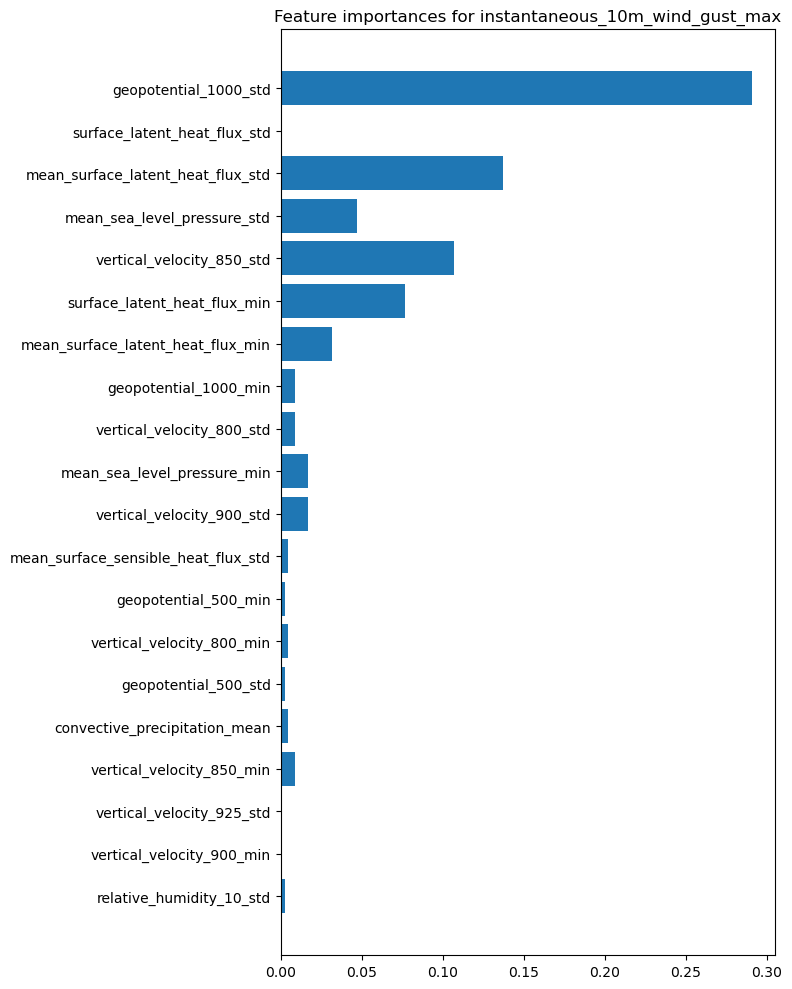

In [18]:
# plot only the feature importance with wind gust max and set the variables on the y axis

fig, ax = plt.subplots(figsize=(8, 10))
ax.set_title("Feature importances for instantaneous_10m_wind_gust_max")
ax.barh(range(subset), importances_max[indices_max][:subset], align="center")
ax.set_yticks(range(subset))
ax.set_yticklabels(var_stat_all_sorted_max[:subset])
# Reverse the y-axis
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# plot only the feature importance with wind gust max and set the variables on the y axis for xgb
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_title("Feature importances for instantaneous_10m_wind_gust_max")
ax.barh(range(subset), importances_max_xgb[indices_max][:subset], align="center")
ax.set_yticks(range(subset))
ax.set_yticklabels(var_stat_all_sorted_max[:subset])
# Reverse the y-axis
ax.invert_yaxis()
plt.tight_layout()
plt.show()